In [1]:
import ast # used for converting column values to lists post-import from csv
import re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from wordcloud import WordCloud

import spacy

from nltk import FreqDist
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (roc_auc_score, plot_confusion_matrix, plot_roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('data/recipes_for_preprocessing.cvs')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482279 entries, 0 to 482278
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                482279 non-null  int64 
 1   id                        482279 non-null  int64 
 2   name                      482279 non-null  object
 3   description               482279 non-null  object
 4   ingredients               482279 non-null  object
 5   ingredients_raw_str       482279 non-null  object
 6   serving_size              482279 non-null  object
 7   servings                  482279 non-null  int64 
 8   steps                     482279 non-null  object
 9   tags                      482279 non-null  object
 10  search_terms              482279 non-null  object
 11  ingredients_list          482279 non-null  object
 12  ingredients_raw_str_list  482279 non-null  object
 13  steps_list                482279 non-null  object
 14  tags

In [4]:
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","['water', 'grits', 'salt', 'cheddar cheese', '...","['4 cups water', '1 cup uncooked old ...","['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","['low-calorie', 'diabetic', 'side', 'vegetaria...",False,False,0,6,4,301,i a sauce pan bring water to a boil slowly add...,"['i', 'a', 'sauce', 'pan', 'bring', 'water', '...",we love grits this is another good way to serv...,"['we', 'love', 'grits', 'this', 'is', 'another..."
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","['onion', 'red bell pepper', 'garlic cloves', ...","['1 medium onion, chopped coarse ', '1 ...","['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","['dinner', 'shrimp']",False,True,0,13,10,138,in a food processor pulse the onion red pepper...,"['in', 'a', 'food', 'processor', 'pulse', 'the...",simple easy and very tasty for when you are in...,"['simple', 'easy', 'and', 'very', 'tasty', 'fo..."
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","['zucchini', 'yellow squash', 'diced tomatoes'...","['2 zucchini, sliced ', '2 small ye...",['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","['italian', 'side', 'vegetarian']",True,False,0,9,1,57,put all ingredients in the crock pot and cook ...,"['put', 'all', 'ingredients', 'in', 'the', 'cr...",this is a good recipe for weight watchers it i...,"['this', 'is', 'a', 'good', 'recipe', 'for', '..."
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"['beef stew meat', 'flour', 'salt', 'allspice'...","['3 lbs beef stew meat', '3 tablespoons...","['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",['dinner'],True,True,1,14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat', 'oven', 'to', 'f', 'cut', 'beef', ...",this is a fabulous stew that came from one of ...,"['this', 'is', 'a', 'fabulous', 'stew', 'that'..."
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",{'dessert'},"['slivered almonds', 'cider vinegar', 'sugar',...","['12 ounces slivered almonds', '1/4 cup ...",['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'prep

In [5]:
df['combined'] = df['description'] + ' ' + df['steps']

In [6]:
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens,combined
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","['water', 'grits', 'salt', 'cheddar cheese', '...","['4 cups water', '1 cup uncooked old ...","['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","['low-calorie', 'diabetic', 'side', 'vegetaria...",False,False,0,6,4,301,i a sauce pan bring water to a boil slowly add...,"['i', 'a', 'sauce', 'pan', 'bring', 'water', '...",we love grits this is another good way to serv...,"['we', 'love', 'grits', 'this', 'is', 'another...","We love grits, this is another good way to ser..."
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","['onion', 'red bell pepper', 'garlic cloves', ...","['1 medium onion, chopped coarse ', '1 ...","['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","['dinner', 'shrimp']",False,True,0,13,10,138,in a food processor pulse the onion red pepper...,"['in', 'a', 'food', 'processor', 'pulse', 'the...",simple easy and very tasty for when you are in...,"['simple', 'easy', 'and', 'very', 'tasty', 'fo...","Simple, easy and very tasty for when you are i..."
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","['zucchini', 'yellow squash', 'diced tomatoes'...","['2 zucchini, sliced ', '2 small ye...",['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","['italian', 'side', 'vegetarian']",True,False,0,9,1,57,put all ingredients in the crock pot and cook ...,"['put', 'all', 'ingredients', 'in', 'the', 'cr...",this is a good recipe for weight watchers it i...,"['this', 'is', 'a', 'good', 'recipe', 'for', '...",This is a good recipe for weight watchers. It ...
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"['beef stew meat', 'flour', 'salt', 'allspice'...","['3 lbs beef stew meat', '3 tablespoons...","['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",['dinner'],True,True,1,14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat', 'oven', 'to', 'f', 'cut', 'beef', ...",this is a fabulous stew that came from one of ...,"['this', 'is', 'a', 'fabulous', 'stew', 'that'...",This is a fabulous stew that came from one of ...
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'pr

In [7]:
y = df['target']

In [8]:
X = pd.DataFrame(df['combined'], index = df.index)

In [9]:
X.head()

,combined
0,"We love grits, this is another good way to ser..."
1,"Simple, easy and very tasty for when you are i..."
2,This is a good recipe for weight watchers. It ...
3,This is a fabulous stew that came from one of ...
4,This is one of our standard holiday gift recip...


In [10]:
len(y)

482279

In [11]:
df_sample = df.sample(50000)
len(df_sample)

50000

In [12]:
df_sample.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens,combined
170644,174241,524218,Chicken Sauce Piquante (Slow Cooker),"Inspired for Joe Simmers, Creole Slow Cooking ...","['boneless skinless chicken thighs', 'salt', '...","[""3 lbs boneless skinless chicken thighs""...",1 (413 g),6,"['Cut the chicken thighs into strips, approxim...","['course', 'main-ingredient', 'cuisine', 'prep...","{'southern', 'dinner', 'chicken'}","['boneless skinless chicken thighs', 'salt', '...",['3 lbs boneless skinless chicken thighs'...,"['Cut the chicken thighs into strips, approxim...","['course', 'main-ingredient', 'cuisine', 'prep...","['dinner', 'southern', 'chicken']",True,True,1,15,3,138,cut the chicken thighs into strips approximate...,"['cut', 'the', 'chicken', 'thighs', 'into', 's...",inspired for joe simmers creole slow cooking n...,"['inspired', 'for', 'joe', 'simmers', 'creole'...","Inspired for Joe Simmers, Creole Slow Cooking ..."
60720,62969,135829,Green Beans and Tortellini,This is fairly easy to make despite the variou...,"['green beans', 'tortellini', 'water', 'white ...","[""1 lb raw stringless green beans"",""1 lb...",1 (373 g),12,"['Bring salted water to a boil in large pot.',...","['30-minutes-or-less', 'time-to-make', 'course...","{'italian', 'low-calorie', 'low-sodium', 'past...","['green beans', 'tortellini', 'water', 'white ...","['1 lb raw stringless green beans', '1 l...","['Bring salted water to a boil in large pot.',...","['30-minutes-or-less', 'time-to-make', 'course...","['low-calorie', 'low-sodium', 'pasta', 'dinner...",True,True,1,13,20,283,bring salted water to a boil in large pot wash...,"['bring', 'salted', 'water', 'to', 'a', 'boil'...",this is fairly easy to make despite the variou...,"['this', 'is', 'fairly', 'easy', 'to', 'make',...",This is fairly easy to make despite the variou...
241570,247218,325664,Incredible Orange Chocolate Chip Muffins,"These muffins are a staple in my house, they a...","['butter', 'sugar', 'oranges%2c zest of', 'egg...","[""1/2 cup softened butter"",""1 cup suga...",1 (47 g),12,"['Preheat oven to 350, have eggs at room tempe...","['30-minutes-or-less', 'time-to-make', 'course...",{'bread'},"['butter', 'sugar', 'oranges%2c zest of', 'egg...","['1/2 cup softened butter', '1 cup sug...","['Preheat oven to 350, have eggs at room tempe...","['30-minutes-or-less', 'time-to-make', 'course...",['bread'],True,False,0,10,4,192,preheat oven to have eggs at room temperature ...,"['preheat', 'oven', 'to', 'have', 'eggs', 'at'...",these muffins are a staple in my house they ar...,"['these', 'muffins', 'are', 'a', 'staple', 'in...","These muffins are a staple in my house, they a..."
171865,175514,4015,Sweet Potato Pie IV,This is the absolute best I have ever put in m...,"['light brown sugar', 'salt', 'cinnamon', 'nut...","[""3/4 cup light brown sugar, lightly packe...",1 (916 g),1,"['Boil until tender, peel, and mash sweet pota...","['15-minutes-or-less', 'time-to-make', 'course...","{'dessert', 'southern'}","['light brown sugar', 'salt', 'cinnamon', 'nut...","['3/4 cup light brown sugar, lightly packe...","['Boil until tender, peel, and mash sweet pota...","['15-minutes-or-less', 'time-to-make', 'course...","['southern', 'dessert']",True,False,0,10,9,56,boil until tender peel and mash sweet potatoes...,"['boil', 'until', 'tender', 'peel', 'and', 'ma...",this is the absolute best i have ever put in m...,"['this', 'is', 'the', 'absolute', 'best', 'i',...",This is the absolute best I have ever put in m...
185916,189948,325846,Asian Grilled Steak With Tangy Wasabi,Adapted from a recipe by Nakano on allrecipes.com,"['seasoned rice vinegar', 'dark soy sauce', 'f...","["""",""1/3 cup seasoned rice vinegar"",""1/4 ...",1

In [13]:
y_sample = df_sample['target']
len(y_sample)

50000

In [14]:
X_sample = pd.DataFrame(df_sample['combined'], index = df_sample.index)

In [15]:
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X,y)
y_res.value_counts()

0    98067
1    98067
Name: target, dtype: int64

In [16]:
X_sample_rus, y_sample_rus = rus.fit_resample(X_sample, y_sample)
y_sample_rus.value_counts()

0    10199
1    10199
Name: target, dtype: int64

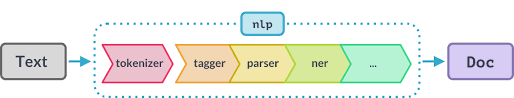

above from spacy documentation and process we'll emulate below
https://spacy.io/usage/processing-pipelines

# Tokenization 

In [17]:
X_sample_rus.head()

,combined
0,This is a great activity for the kids! They l...
1,"I love a good down-to-earth chunky guacamole, ..."
2,"If you like chocolate and caramel, then you ha..."
3,Another great chicken salad for take-to-work l...
4,This is dish that will serve 24 (7 or 8 shrimp...


In [18]:
cook_words = {'garlic', 'milk', 'pepper', 'garlic cloves', 'salt', 'lemon juice', 'brown sugar', 'flour', 'parmesan cheese', 'eggs', 'onion', 'salt and pepper', 'butter', 'sugar', 'water', 'olive oil', 'vegetable oil'}

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # disabling what we don't need to lemmatize
nlp.Defaults.stop_words |= cook_words

In [20]:
test = X_sample_rus.head(10)

In [21]:
# test['lemma'] = test['lowercase'].apply(lambda x: ' '.join([y.lemma_ for y in nlp(x) if not y.is_stop]))

In [22]:
test.head()

,combined
0,This is a great activity for the kids! They l...
1,"I love a good down-to-earth chunky guacamole, ..."
2,"If you like chocolate and caramel, then you ha..."
3,Another great chicken salad for take-to-work l...
4,This is dish that will serve 24 (7 or 8 shrimp...


In [23]:
test['combined'].iloc[3]

"Another great chicken salad for take-to-work lunches. ['Add the shredded chicken to a large bowl.', 'Add in the tomatoes, peas, celery, and green onion (if not serving immediately, add the peas just before serving).', 'Cook pasta per package directions; drain pasta and toss with oil.', 'Add parmesan to the pasta; toss to coat.', 'When the pasta is cooled to room temperature, add it to the chicken mixture.', 'To make the dressing: whisk the vinegar, mustard, garlic, salt, and pepper together in a small bowl.', 'Add in the olive oil, whisking until it is incorporated.', 'Pour the dressing over the salad; toss gently but thoroughly.', 'Cover and refrigerate for up to 8 hours; serve chilled.']"

In [24]:
#test['basic'] = test['lemma'].apply(lambda x: ' '.join([str(y) for y in nlp(x) if not y.is_punct]))

In [ ]:
# def spacy_cleaning(x, nlp):
#     '''takes in a spacy Document-type (aka a collection of tokens) and returns either a string tokens that have been
#     cleaned of:
#                 - stop words
#                 - puntuation 
#                 - numbers
    
#     as well as lemmetizes the results.
    
#     Inputs:
#     x - spacy Document
    
#     Returns:
#     Spacy Document or string
#     '''

#     x_nlp = nlp(x)

#     # lemmatize the text, removing stopwords and punctuation
#     lemma = [y.lemma_ for y in x_nlp if not (y.is_stop) and not (y.is_punct)] 

    
#     #replacing URLs with a generic "URL" and removing numbers
#     no_web = [re.sub(r'http\S+', 'URL', word) for word in lemma]
#     no_num = [re.sub(r'[0-9]', '', word) for word in no_web]
    
#     #removes white spaces and odd single characters
#     final = [x.lower() for x in no_num if (len(x)>1)]

#     return " ".join(final)
                                     

In [25]:
import nlp_project

In [26]:
test['lemma'] = test['combined'].apply(lambda x: nlp_project.spacy_cleaning(x,nlp))
    

C:\Users\alexm\AppData\Local\Temp/ipykernel_8916/3852621893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lemma'] = test['combined'].apply(lambda x: nlp_project.spacy_cleaning(x,nlp))


In [27]:
test.head()

,combined,lemma
0,This is a great activity for the kids! They l...,great activity kid love ice cream good fill ga...
1,"I love a good down-to-earth chunky guacamole, ...",love good earth chunky guacamole want dress bi...
2,"If you like chocolate and caramel, then you ha...",like chocolate caramel recipe try great time y...
3,Another great chicken salad for take-to-work l...,great chicken salad work lunch add shredded ch...
4,This is dish that will serve 24 (7 or 8 shrimp...,dish serve shrimp person simply triple ingredi...


In [ ]:
test['lemma'].iloc[7]

In [ ]:
X_sample_rus['lowercase'] = X_sample_rus['combined'].apply(lambda x: x.lower())

In [ ]:
X_sample_rus.head(3)

In [ ]:
X_sample_rus.info()

In [ ]:
X_sample_rus['lemma'] = X_sample_rus['combined'].apply(lambda x: ' '.join([y.lemma_ for y in nlp(x) if not y.is_stop]))

# Let's figure out how long this is gonna take

In [ ]:
X_sample_rus['lemma'] = X_sample_rus['combined'].apply(lambda x: spacy_cleaning(x))


In [ ]:
X_sample_rus.tail()

In [ ]:
X_sample_rus['tokens'] = X_sample_rus['combined'].apply(lambda x: x.split()) 